# Imports

In [1]:
# Import standard libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# API
import requests
import snowflake.connector

# Date
import datetime as dt
import time
from datetime import timedelta

In [2]:
# # # Gets the cursor
# con = snowflake.connector.connect(
#     user='meagan',
#     password='',
#     account='hu40871.us-east-1',
#     warehouse='ANALYSIS'
#     )

# cur = con.cursor()

# # insert query here
# cur.execute('''
#     SELECT  * 
#     FROM    "WAREHOUSE"."GOLD"."SUBSCRIPTION_RETENTION"
#            ''')

# df=cur.fetch_pandas_all()
# df.head()

silver = pd.read_csv('Acuity.csv')
gold_sub = pd.read_csv('GOLD.csv')

## Acuity

In [3]:
# Create a copy of the DB
silver_acuity = silver.copy()
silver_acuity.shape

(23981, 20)

In [4]:
# Change dates to datetime Dtype
silver_acuity['APPOINTMENT_BODY_DATE'] = pd.to_datetime(silver_acuity['APPOINTMENT_BODY_DATE'])

# Drop unneeded columns
silver_acuity.drop(columns=['EVENT_TS', 'EVENT_TS_UTC', 'ANONYMOUS_ID','APPOINTMENT_BODY_FIRST_NAME',
       'APPOINTMENT_BODY_DATETIME_CREATED', 'APPOINTMENT_BODY_CALENDAR_ID','APPOINTMENT_BODY_CALENDAR_TIMEZONE',\
                    'APPOINTMENT_BODY_TIMEZONE', 'APPOINTMENT_BODY_LAST_NAME', 'APPOINTMENT_BODY_ID',\
                    'APPOINTMENT_BODY_NO_SHOW', \
                    'APPOINTMENT_TYPE_ID'], inplace=True)

# Check for null values
# sns.heatmap(silver_acuity.isnull(), cbar=False)
# silver_acuity.isnull().sum()

In [5]:
silver_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                      19913
Hair Mineral Analysis Appointment       2985
Follow Up Consultation                   544
Customer consultation                    201
Case Study                                41
Hair Mineral Analysis - Acquisition       19
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [6]:
silver_acuity['EVENT'].value_counts()

appointment_changed        17811
appointment_scheduled       5097
appointment_rescheduled      649
appointment_canceled         424
Name: EVENT, dtype: int64

In [7]:
# drop irrelevant appointments
na_dict= {'appointment_canceled' : np.nan,
'appointment_changed' : np.nan,
'appointment_rescheduled' : np.nan}

silver_acuity['EVENT'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['EVENT'].value_counts()

appointment_scheduled    4982
Name: EVENT, dtype: int64

In [8]:
# # drop irrelevant appointments
# na_dict= {'True' : np.nan}

# silver_acuity['APPOINTMENT_BODY_CANCELED'].replace(na_dict, inplace = True)
# silver_acuity.dropna(inplace = True)
# # silver_acuity['APPOINTMENT_BODY_CANCELED'].value_counts()

silver_acuity['APPOINTMENT_BODY_CANCELED'].value_counts()

False    4981
True        1
Name: APPOINTMENT_BODY_CANCELED, dtype: int64

In [9]:
# drop irrelevant appointments
na_dict= {'Hair Mineral Analysis - Acquisition':np.nan,
          'Follow Up Consultation':np.nan,
          'Customer consultation':np.nan,
          'Case Study':np.nan}

silver_acuity['APPOINTMENT_BODY_TYPE'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                    4205
Hair Mineral Analysis Appointment     596
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [10]:
silver_acuity.shape

(4801, 8)

In [40]:
silver_acuity.head()

,EVENT,APPOINTMENT_BODY_CALENDAR,EMAIL,APPOINTMENT_BODY_DATE,APPOINTMENT_BODY_DURATION,APPOINTMENT_DATE_TIME,APPOINTMENT_BODY_TYPE,APPOINTMENT_BODY_CANCELED,Today,Complete
1,appointment_scheduled,"Dr. Lauren Geyman, ND",kay29485@yahoo.com,2020-12-15,20.0,2020-12-15 09:25:00.000,Hair Consultation,False,2021-02-08,True
2,appointment_scheduled,"Dr. Melissa Anzelone, ND",sharma.reema89@gmail.com,2020-12-14,20.0,2020-12-14 11:30:00.000,Hair Consultation,False,2021-02-08,True
3,appointment_scheduled,"Dr. Nadia Musavvir, ND",hr_girl69@yahoo.com,2021-01-08,20.0,2021-01-08 08:30:00.000,Hair Consultation,False,2021-02-08,True
4,appointment_scheduled,"Dr. Anya Arthen, ND",keller57@bellsouth.net,2021-01-08,20.0,2021-01-08 09:10:00.000,Hair Consultation,False,2021-02-08,True
5,appointment_scheduled,"Dr. Nadia Musavvir, ND",jenlp88@outlook.com,2021-01-05,20.0,2021-01-05 10:35:00.000,Hair Consultation,False,2021-02-08,True


In [11]:
#Round to the day
silver_acuity['APPOINTMENT_BODY_DATE'] = silver_acuity['APPOINTMENT_BODY_DATE'].dt.round('D')

silver_acuity['Today'] = pd.Timestamp('today')
silver_acuity['Today'] = silver_acuity['Today'].dt.round('D')

silver_acuity['Complete'] = (silver_acuity['Today']>silver_acuity['APPOINTMENT_BODY_DATE'])
silver_acuity['Complete'].value_counts()

True     4237
False     564
Name: Complete, dtype: int64

In [12]:
# Remove appointments in the future
silver_acuity['Complete'] = silver_acuity['Complete'].astype('str')

# drop irrelevant appointments
na_dict= {'False' : np.nan}

silver_acuity['Complete'].replace(na_dict, inplace = True)
silver_acuity.dropna(inplace = True)
silver_acuity['Complete'].value_counts()

True    4237
Name: Complete, dtype: int64

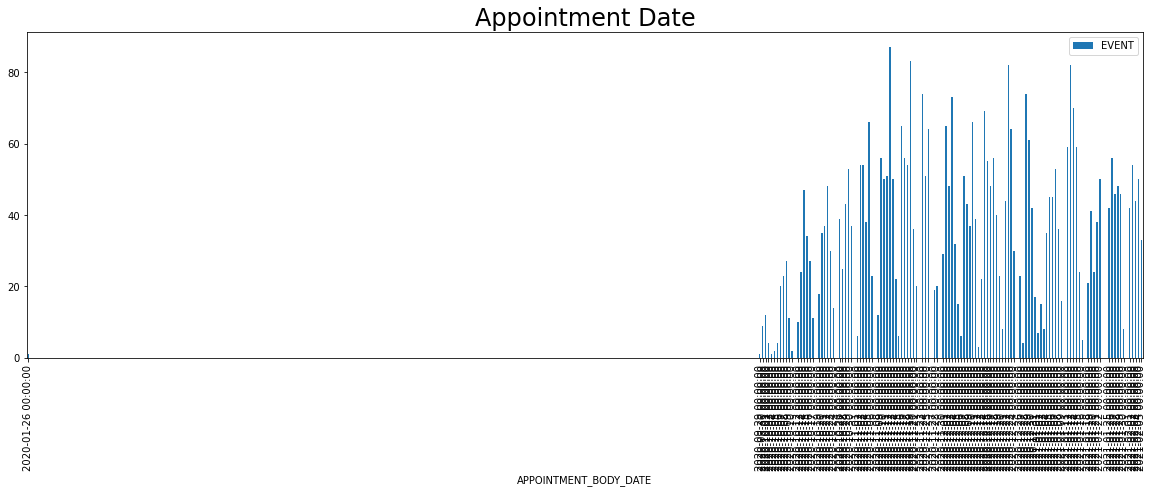

In [13]:
# Group by event, for a visual only 
chart = silver_acuity.groupby(["APPOINTMENT_BODY_DATE"]).agg({'EVENT':'count'})
chart.isna().sum()

chart.plot(kind='bar',figsize=(20,6))
plt.title("Appointment Date", size= 24)
plt.show()

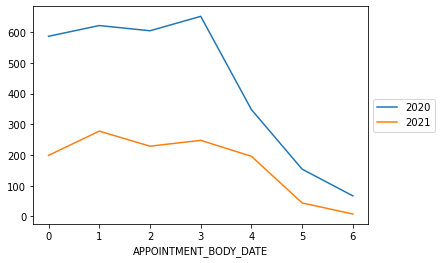

In [14]:
(silver_acuity.groupby([silver_acuity['APPOINTMENT_BODY_DATE'].dt.dayofweek,\
                       silver_acuity['APPOINTMENT_BODY_DATE'].dt.year])\
 ['EVENT'].count()).unstack().plot(kind='line')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [15]:
min(silver_acuity['APPOINTMENT_BODY_DATE'])

Timestamp('2020-01-26 00:00:00')

In [16]:
# min(silver_acuity['APPOINTMENT_BODY_DATE'])
# max(silver_acuity['APPOINTMENT_BODY_DATE'])

# Looking at specific email addresses
# silver_acuity.loc[silver_acuity['EMAIL']=='XXXX@yahoo.com']

# AGG
# clean_acuity = silver_acuity.loc[silver_acuity.groupby('EMAIL')['APPOINTMENT_BODY_DATE'].idxmin()]
# clean_acuity.shape

(3662, 10)

In [17]:
clean_acuity['APPOINTMENT_BODY_TYPE'].value_counts()

Hair Consultation                    3298
Hair Mineral Analysis Appointment     364
Name: APPOINTMENT_BODY_TYPE, dtype: int64

In [18]:
#QA instances
smail = clean_acuity['EMAIL'].nunique()
print ('unique emails = ',smail)

unique emails =  3662


In [41]:
# clean_acuity = clean_acuity[['EMAIL','APPOINTMENT_BODY_CALENDAR',\
#                           'APPOINTMENT_BODY_DATE',\
#                          'APPOINTMENT_BODY_TYPE']]

clean_acuity = silver_acuity.groupby('EMAIL').agg({"APPOINTMENT_BODY_DATE":'min',\
                                'APPOINTMENT_BODY_TYPE':'last',\
                                'APPOINTMENT_BODY_CALENDAR':'last'\
                               })
clean_acuity.shape

(3662, 3)

In [42]:
clean_acuity.head()

,APPOINTMENT_BODY_DATE,APPOINTMENT_BODY_TYPE,APPOINTMENT_BODY_CALENDAR
EMAIL,,,
101akpatel@gmail.com,2020-12-18,Hair Consultation,"Dr. Nadia Musavvir, ND"
11consesa@gmail.com,2020-11-17,Hair Consultation,"Dr. Katelyn Cloyd, ND"
1christinegallegos@gmail.com,2021-01-22,Hair Consultation,"Dr. Nicole Klughers, ND"
22reverie@gmail.com,2020-11-05,Hair Consultation,"Dr. Nicole Klughers, ND"
2reachmari@gmail.com,2021-01-12,Hair Consultation,"Dr. Nicole Klughers, ND"


## SUB

In [21]:
# Create a copy of the dataframe
gold = gold_sub.copy()

# Change dates to datetime 
gold['FIRST_ORDER_AT'] = pd.to_datetime(gold['FIRST_ORDER_AT'])
gold.columns

Index(['EMAIL', 'ITEM_GENDER', 'ITEM_SUB_TYPE', 'ITEM_PRODUCT_CORE_CATEGORY',
       'FIRST_ORDER_AT', 'TOTAL_ORDERS', 'TOTAL_ORDER_VALUE',
       'GROSS_ORDER_VALUE'],
      dtype='object')

In [22]:
gold.dropna(inplace = True)
gold.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 695650 entries, 0 to 736629
Data columns (total 8 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   EMAIL                       695650 non-null  object        
 1   ITEM_GENDER                 695650 non-null  object        
 2   ITEM_SUB_TYPE               695650 non-null  object        
 3   ITEM_PRODUCT_CORE_CATEGORY  695650 non-null  object        
 4   FIRST_ORDER_AT              695650 non-null  datetime64[ns]
 5   TOTAL_ORDERS                695650 non-null  int64         
 6   TOTAL_ORDER_VALUE           695650 non-null  float64       
 7   GROSS_ORDER_VALUE           695650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 47.8+ MB


In [23]:
# min(gold['FIRST_ORDER_AT'])
# max(gold['FIRST_ORDER_AT'])

yyy = gold.shape
gemail = gold['EMAIL'].nunique()
print ('shape = ',yyy)
print ('unique emails = ',gemail)

shape =  (695650, 8)
unique emails =  21602


In [24]:
# Aggregate
df = gold.groupby('EMAIL').agg({"FIRST_ORDER_AT":'min',\
                                'TOTAL_ORDER_VALUE':'mean',\
                                'TOTAL_ORDERS':'mean'\
                                ,'ITEM_GENDER':'last',\
                                'ITEM_SUB_TYPE':'last',\
                                'ITEM_PRODUCT_CORE_CATEGORY':'last'\
                               })
df.shape

(21602, 6)

<AxesSubplot:ylabel='EMAIL'>

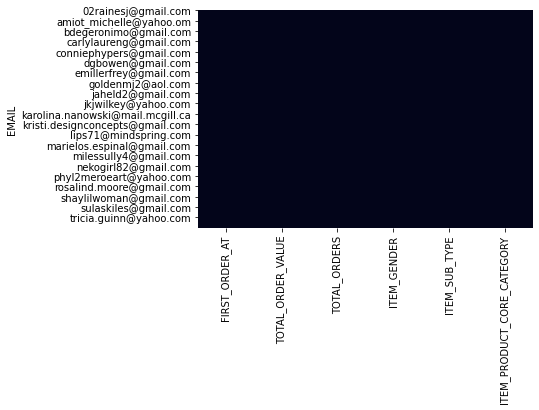

In [25]:
sns.heatmap(df.isnull(), cbar=False)

In [26]:
df.dropna().describe()

,TOTAL_ORDER_VALUE,TOTAL_ORDERS
count,21602.000000,21602.000000
mean,1251.871686,15.413249
std,760.112543,9.287685
min,0.000000,1.000000
25%,638.000000,8.000000
50%,1092.000000,13.000000
75%,1786.000000,22.000000
max,7847.000000,93.000000


## Merge

In [43]:
sub1 = pd.merge(clean_acuity,df,how='left',on='EMAIL')
sub1.shape

(3662, 9)

<AxesSubplot:ylabel='EMAIL'>

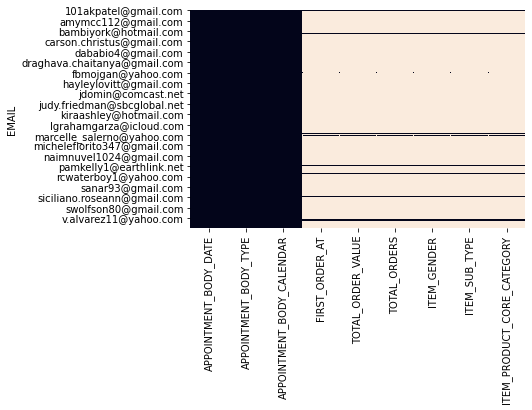

In [44]:
sns.heatmap(sub1.isnull(), cbar=False)

In [31]:
# Create a copy of the dataframe
sub = sub1.copy()

sub = sub[[ 'EMAIL', 'FIRST_ORDER_AT','APPOINTMENT_BODY_DATE',\
           'ITEM_PRODUCT_CORE_CATEGORY', 'ITEM_SUB_TYPE','ITEM_GENDER',\
           'TOTAL_ORDERS','TOTAL_ORDER_VALUE']]

sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3662 entries, 0 to 3661
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   EMAIL                       3662 non-null   object        
 1   FIRST_ORDER_AT              182 non-null    datetime64[ns]
 2   APPOINTMENT_BODY_DATE       3662 non-null   datetime64[ns]
 3   ITEM_PRODUCT_CORE_CATEGORY  182 non-null    object        
 4   ITEM_SUB_TYPE               182 non-null    object        
 5   ITEM_GENDER                 182 non-null    object        
 6   TOTAL_ORDERS                182 non-null    float64       
 7   TOTAL_ORDER_VALUE           182 non-null    float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 257.5+ KB


In [32]:
sub = sub.groupby('EMAIL').agg({"FIRST_ORDER_AT":'min',"APPOINTMENT_BODY_DATE":'min',\
                                'TOTAL_ORDER_VALUE':'mean',\
                                'TOTAL_ORDERS':'mean'\
                                ,'ITEM_GENDER':'last',\
                                'ITEM_SUB_TYPE':'last',\
                                'ITEM_PRODUCT_CORE_CATEGORY':'last'\
                               })
sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3662 entries, 101akpatel@gmail.com to zusette1950@yahoo.com
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   FIRST_ORDER_AT              182 non-null    datetime64[ns]
 1   APPOINTMENT_BODY_DATE       3662 non-null   datetime64[ns]
 2   TOTAL_ORDER_VALUE           182 non-null    float64       
 3   TOTAL_ORDERS                182 non-null    float64       
 4   ITEM_GENDER                 182 non-null    object        
 5   ITEM_SUB_TYPE               182 non-null    object        
 6   ITEM_PRODUCT_CORE_CATEGORY  182 non-null    object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 228.9+ KB


In [33]:
# df_total = df['TOTAL_ORDER_VALUE'].mean()
# sub_total = sub['TOTAL_ORDER_VALUE'].mean()
# print('Subscription Total Order Value = ',df_total)
# print('Sub + Consult Total Order Value = ',sub_total)

# df_orders = df['TOTAL_ORDERS'].mean()
# sub_total = sub['TOTAL_ORDERS'].mean()
# print('Subscription Total Orders = ',df_orders)
# print('Sub + Consult Total Orders = ',sub_total)

In [34]:
# sub['FIRST_ORDER_AT']=pd.to_datetime(sub['FIRST_ORDER_AT'])

# sub['TimeDifference'] = \
# (((sub['APPOINTMENT_BODY_DATE']))-(sub['FIRST_ORDER_AT']))

# submail = sub['EMAIL'].nunique()
# print ('unique emails = ',submail)

In [35]:
# clean up item sub
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan 2']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan,GrowthPlan 3,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 2,GrowthPlan 3,GrowthPlan 3']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 3,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='Prepay 6', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 3,GrowthPlan 3,GrowthPlan 2,GrowthPlan 3,GrowthPlan 3,GrowthPlan 3,GrowthPlan 2', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 3,GrowthPlan 2,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan 2', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan ', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 2', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan 3']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan,GrowthPlan', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,Non-Sub', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 2,GrowthPlan,GrowthPlan 3', 'ITEM_SUB_TYPE']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan 3,GrowthPlan 3,Non-Sub']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='Non-Sub,GrowthPlan 2']= 'Combination'
# sub.loc[sub['ITEM_SUB_TYPE'] =='GrowthPlan,GrowthPlan 3']= 'Combination'

sub['ITEM_SUB_TYPE'].value_counts()

GrowthPlan                 127
GrowthPlan 3                41
GrowthPlan 2                13
GrowthPlan,GrowthPlan 3      1
Name: ITEM_SUB_TYPE, dtype: int64

In [36]:
# sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Women,Men']= 'Women'
# sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Combination']= 'Balance'
# sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Women,Balance']= 'Balance'
# sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Men,Men']= 'Men'
# sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Balance,Men']= 'Balance'
# sub.loc[sub['ITEM_PRODUCT_CORE_CATEGORY'] =='Men,Women,Women']= 'Women'

sub['ITEM_PRODUCT_CORE_CATEGORY'].value_counts()

Women      105
Balance     42
Men         34
Men,Men      1
Name: ITEM_PRODUCT_CORE_CATEGORY, dtype: int64

In [37]:
# # clean up item gender
# gold.loc[gold['ITEM_GENDER'] =='Men,Women', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Women,Men,Women', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Men,Women,Men,Women,Women,Women,Men,Men', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Men,Women,Women', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Women,Women,Men', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Women,Men,Women,Women', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Women,Men', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Women,All', 'ITEM_GENDER']= 'Women'
# gold.loc[gold['ITEM_GENDER'] =='Women,Women,Women,Women', 'ITEM_GENDER']= 'Women'
# gold.loc[gold['ITEM_GENDER'] =='Women,Women', 'ITEM_GENDER']= 'Women'
# gold.loc[gold['ITEM_GENDER'] =='Men,Men', 'ITEM_GENDER']= 'Men'
# gold.loc[gold['ITEM_GENDER'] =='Women,Women,Men,Women,Men,Men,Men,Women', 'ITEM_GENDER']= 'Combination'
# gold.loc[gold['ITEM_GENDER'] =='Women,Women,Women,Men']= 'Women'

sub['ITEM_GENDER'].value_counts()

Women      147
Men         34
Men,Men      1
Name: ITEM_GENDER, dtype: int64

In [38]:
# Export data
sub.to_csv('sub.csv')